# Exploring Land Cover Data

:::{eval-rst}
:opticon:`tag`
:badge:`[Environment],badge-primary`
:badge:`Exploration,badge-secondary`
:::

## Context
### Purpose
This notebook introduces manipulation and exploratory analysis of classified land cover data. 

### Dataset description
There are now many classified (categorical) land cover data productes that are useful for Environmental Data Science. These include:
- [ESA CCI land cover](https://www.esa-landcover-cci.org/), 300m spatial resolution global extent for years 1992-2015 
- [Copernicus Global Land Cover](https://zenodo.org/communities/copernicus-land-cover), 100m spatial resolution global extent for years 2015-2019 
- [USGS LCMAP](https://www.usgs.gov/special-topics/lcmap/data), 30m spatial resolution for USA for years 1985-2020
- [UKCEH LCMs](https://www.ceh.ac.uk/data/ukceh-land-cover-maps), various spatial resolutions for UK for various years 1990-2020
- [mapbiomas](https://mapbiomas.org/en), 30m spatial resolution for Brazil for years 1985-2020
- [Impact Observatory](https://planetarycomputer.microsoft.com/dataset/io-lulc-9-class), 10m spatial resolution global extent for 2017-2021

These products are provided as 2D rasters (spatial) or 3D data cubes (spatio-temporal). The number and classification of discrete land cover classes varies between products, but at their most basic will distinguish between broad land covers such as 'grassland', 'forest' and 'built-up'. The nominal (categorical) character of the data influences the types of analysis appropriate. 

### Highlights
* Read land cover product data
* Plot categorical maps
* Analyse aggregate change (through bar charts and similar visualisation) 
* Analyse zonal change (using ancillary vector data)
* Analyse pixel-by-pixel change (including use of sankey diagrams)

### Contributions

#### Notebook
- James Millington (author), Dept of Geography, King's College London, [@jamesdamillington](https://github.com/jamesdamillington)

#### Dataset
- [Esri](https://www.esri.com/) (licensor)
- [Impact Observatory](https://www.impactobservatory.com/) (processor, producer, licensor)
- [Microsoft](https://planetarycomputer.microsoft.com/) (host)

#### Code
- Data loading code built on snippet [from @acocac](https://github.com/alan-turing-institute/environmental-ds-book/issues/99#issuecomment-1185550940) via [ODC.stac docs](https://odc-stac.readthedocs.io/en/latest/notebooks/stac-load-e84-aws.html) and a [Microsoft Planetary example notebook](https://planetarycomputer.microsoft.com/dataset/io-lulc#Example-Notebook).  

## Load libraries

In [38]:
#system
import os
import warnings
warnings.filterwarnings(action='ignore')

#data handling
import pystac_client
import geopandas as gpd
import odc.stac
import rasterio
from pystac.extensions.item_assets import ItemAssetsExtension
import numpy as np
import pandas as pd

#visualisation
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

## Set project structure
*The cell below creates a separate folder to save the notebook outputs. This facilitates the reader to inspect inputs/outputs stored within a defined destination folder.*

In [2]:
notebook_folder = './general-exploration-landcover'
if not os.path.exists(notebook_folder):
    os.makedirs(notebook_folder)

## Load data
*Load full dataset from original or mirror sources. If the license of the dataset permits, we suggest creating sample data (preprocessed) for the notebook stored in a data repository e.g. Zenodo.*

This notebook uses data from [Impact Observatory](https://planetarycomputer.microsoft.com/dataset/io-lulc-9-class), 10m spatial resolution global extent for 2017-2021. These data are hosted online by [Microsoft's Planetary Computer](https://planetarycomputer.microsoft.com/) which enable you, the user, to run the code in the cloud (e.g. via binder). However, accessing the data from the cloud adds some steps that would not be necssary had you downloaded the data to your local machine. Consequently, in future for your own work you might ignore these first _Load cload data_ code blocks and work from _Load local data_.   

### Load Cloud Data

In [43]:
#Specify center point of the study area
x, y = (-55.30, -9.75)

#define a square bounding box for the study area
km2deg = 1.0 / 111
r = 20 * km2deg   #40 x 40 km
study_bbox = (x - r, y - r, x + r, y + r)

In [44]:
#use pystac-client
#https://pystac-client.readthedocs.io/en/latest/
catalog = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

print(f"Object class: {type(catalog)}")
print(f"Title: {catalog.title or 'N/A'}")
print(f"Description: {catalog.description or 'N/A'}")

Object class: <class 'pystac_client.client.Client'>
Title: Microsoft Planetary Computer STAC API
Description: Searchable spatiotemporal metadata describing Earth science datasets hosted by the Microsoft Planetary Computer


In [45]:
#https://pystac-client.readthedocs.io/en/latest/tutorials/pystac-client-introduction.html#API-Search
query = catalog.search(
    collections=["io-lulc-9-class"],
    limit=100,
    bbox=study_bbox
)

#https://pystac-client.readthedocs.io/en/latest/tutorials/pystac-client-introduction.html#Items
items = list(query.get_items())
print(f"Found: {len(items):d} datasets")

print(items)

Found: 5 datasets
[<Item id=21L-2021>, <Item id=21L-2020>, <Item id=21L-2019>, <Item id=21L-2018>, <Item id=21L-2017>]


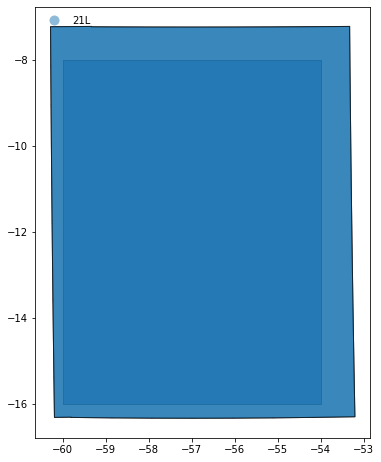

In [46]:
# Convert STAC items into a GeoJSON FeatureCollection
stac_json = query.get_all_items_as_dict()
gdf = gpd.GeoDataFrame.from_features(stac_json, "epsg:4326")

#plot to check study area does not cover multiple lc images 
fig = gdf.plot(
    "io:tile_id",
    edgecolor="black",
    categorical=True,
    aspect="equal",
    alpha=0.5,
    figsize=(6, 12),
    legend=True,
    legend_kwds={"loc": "upper left", "frameon": False, "ncol": 1},
)

##ADD CODE FOR STUDY LOCATION BBOX HERE
##MAYBE PROVIDE EXAMPLE FOR CASE WHERE STUDY AREA WOULD COVER MULTIPLE IMAGES (e.g. centre located at x, y = (-55.30, -15.75))

plt.show()

In [47]:
crs = "epsg:3857"

#load at 10m resolution
lc10 = odc.stac.load(
    items,
    bands=("data"),
    crs=crs,
    resolution=10,
    chunks={},  # <-- use Dask
    groupby="start_datetime",
    bbox=study_bbox,
)
print(lc10.dims)

#load at 100m resolution
lc100 = odc.stac.load(
    items,
    bands=("data"),
    crs=crs,
    resolution=100,
    chunks={},  # <-- use Dask
    groupby="start_datetime",
    bbox=study_bbox,
)
print(lc100.dims)

Frozen({'y': 4071, 'x': 4012, 'time': 5})
Frozen({'y': 408, 'x': 402, 'time': 5})


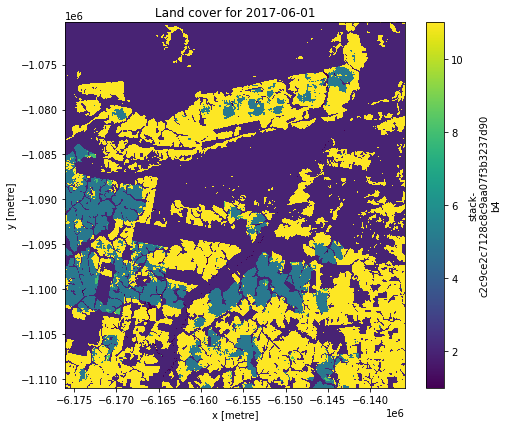

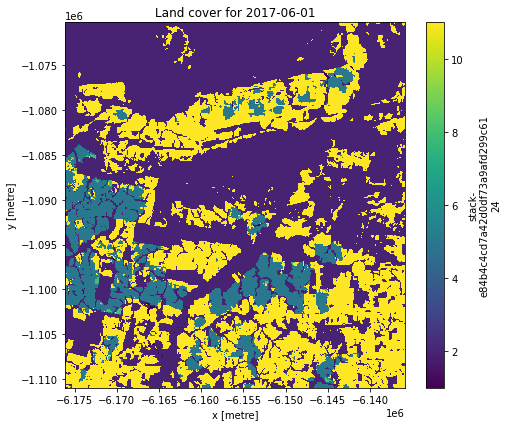

In [50]:
ts=0  #which year layer
lc10.isel(time=ts).to_array("band").plot.imshow(
        col="band",
        size=6
    )

plt.title("Land cover for {0}".format(lc10["time"][ts].values.astype('datetime64[D]')))   #https://stackoverflow.com/a/26895491
plt.show()

lc100.isel(time=ts).to_array("band").plot.imshow(
        col="band",
        size=6
    )

plt.title("Land cover for {0}".format(lc100["time"][ts].values.astype('datetime64[D]')))   #https://stackoverflow.com/a/26895491
plt.show()


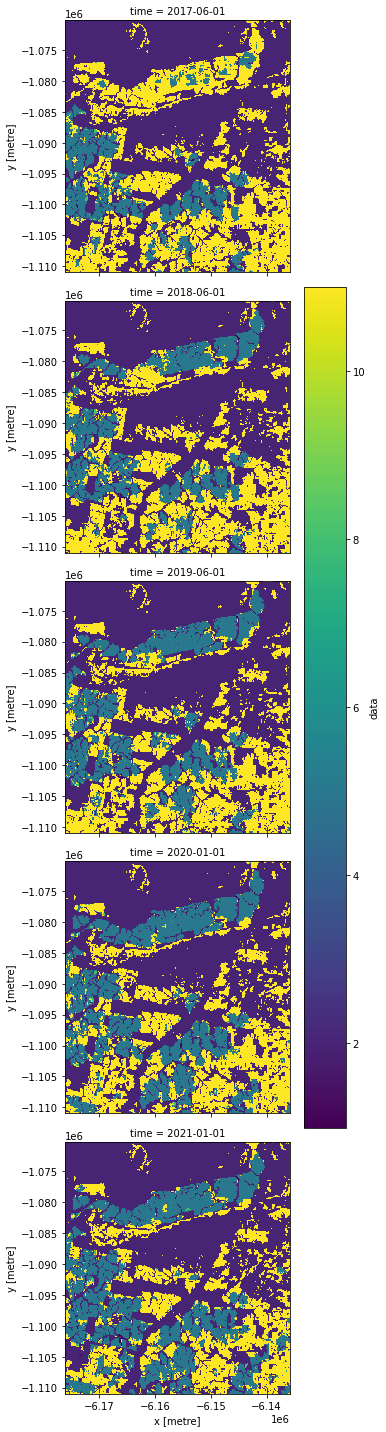

In [53]:
lc100['data'].plot(row="time", size=4)  
plt.show()

{'data': <pystac.extensions.item_assets.AssetDefinition object at 0x7f0d607e73a0>}


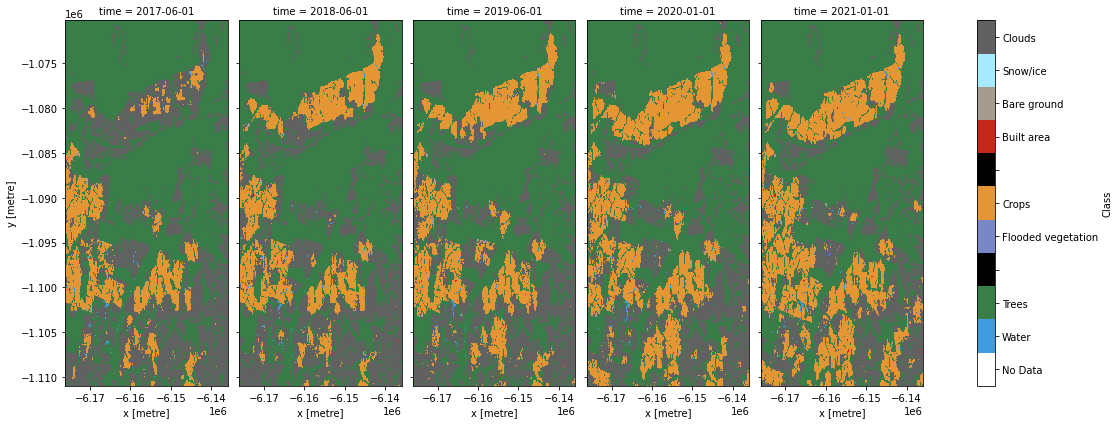

In [54]:
#class names and IDs are held in an 'asset' of the collection 
collection = catalog.get_collection("io-lulc-9-class")
ia = ItemAssetsExtension.ext(collection)

print(ia.item_assets)

iaa = ia.item_assets["data"]

#print(iaa.properties)

#get the names of the land cover classes with their ID in the raster (as a dictionary, name:ID)
class_names = {iaa["summary"]: iaa["values"][0] for iaa in iaa.properties["file:values"]}

#flip the keys:values in the dictionary (to create ID:name)
values_to_classes = {v: k for k, v in class_names.items()}

class_count = len(class_names)

with rasterio.open(items[0].assets["data"].href) as src:
    colormap_def = src.colormap(1)  # get metadata colormap for band 1
    colormap = [
        np.array(colormap_def[i]) / 255 for i in range(max(class_names.values()))
    ]  # transform to matplotlib color format

cmap = ListedColormap(colormap)

vmin = 0
vmax = max(class_names.values())

p = lc100.data.plot(
    col="time",
    cmap=cmap,
    vmin=vmin,
    vmax=vmax,
    figsize=(16, 6),
)
ticks = np.linspace(0.5, 10.5, 11)
labels = [values_to_classes.get(i, "") for i in range(cmap.N)]
p.cbar.set_ticks(ticks, labels=labels)
p.cbar.set_label("Class")

## Visualisation
*Create a visual narrative of the dataset! We suggest exploring libraries suited for interactive plotting e.g. Holoviews, Panel, Bokeh.*

## Summary
*Provide 3-5 bullet points summarising the main aspects of the dataset and tools covered in the notebook.*

* Sentence 1 e.g. `tool-name` to perform...
* Sentence 2 e.g. `tool-name` to perform...

## Additional information
**Dataset**: Type here details of dataset(s) version.

**License**: The code in this notebook is licensed under the MIT License. The Environmental Data Science book is licensed under the Creative Commons by Attribution 4.0 license. See further details [here](https://github.com/alan-turing-institute/environmental-ds-book/blob/master/LICENSE.md).

**Contact**: If you have any suggestion or report an issue with this notebook, feel free to [create an issue](https://github.com/alan-turing-institute/environmental-ds-book/issues/new/choose) or send a direct message to [environmental.ds.book@gmail.com](mailto:environmental.ds.book@gmail.com).

In [10]:
from datetime import date
print(f'Last tested: {date.today()}')

Last tested: 2022-07-18
